# Autoencoder その2; 蒸留,Convolutional Autoencoder, Denoising Autoencoder(DAE)

## 5. 蒸留（distillation）

一般に、主に画像認識においてCNNは普通のニューラルネットワーク（multilayer perceptron, MLP）<br>
よりもパフォーマンスが高いことが知られています。<br>
AutoencoderでもCNNを使うことにより、うまく学習できることが期待されます。

Urban et al. 2016<br>
https://arxiv.org/pdf/1603.05691v2.pdf<br>
深さや畳み込みが本当に重要かどうかを実験により検証しています。<br>
この研究では、蒸留（distillation）という手法を使って学習させています。

蒸留では教師モデルと生徒モデルを用意します。<br>
通常は訓練データのラベルを使って学習しますが、蒸留ではこのラベルではなく、<br>
<span style="color:red">教師モデルによる予測をラベルとして生徒モデルを学習</span>させます。

生徒モデルは、教師モデルの予測と生徒モデルの予測が最小となるように<br>
学習していきます（ラベルも両方使う場合があります。参考：Hinton et al. 2015）。<br>
https://www.cs.toronto.edu/~hinton/absps/distillation.pdf

通常のラベルを使った学習では、例えば猫に関する訓練データであれば、<br>
猫以外のクラスに属する確率はゼロとして扱われます。<br>
しかし、教師モデルの予測では、猫である確率が一番高くとも、犬や虎である確率も<br>
僅かに存在しているはずです。<br>
生徒モデルは、ラベルとは異なる他のクラスである確率も含めて学習することになります。

蒸留を行うと、<span style="color:red">生徒モデルは教師モデルよりも浅く小さなモデルであるにも関わらず、<br>
教師モデルと同等の正確度を出せる</span>ことが分かっています。

教師モデルの予測は、正解となるクラスだけでなく、それ以外のクラスに対する確率も<br>
含んでいるため、より多くの情報を持っていることになります。<br>
これにより、生徒モデルはうまく学習できると考えられます。

生徒モデルは教師モデルよりも小さなモデルであるため、少ない計算量で<br>
済むようになります。<b>何かサービスをリリースする時には蒸留を使って、<br>
生徒モデルをデプロイすると良さそう</b>です。

Deep Autoencoderの章で、中間層が1層以上あれば十分な表現力を持てるが<br>
うまく学習できるかどうかは別問題という話をしました。<br>
今のところ、<span style="color:red">浅いニューラルネットワークに学習させる最も良い方法は蒸留だ</span>と考えられます。<br>

蒸留によって限界性能を引き出しつつ、層数や畳み込みによってどう正確度が変化するか<br>
を見れば、層数や畳み込みの重要性をある程度見極めることができるでしょう。<br>
では実験結果を見てみましょう。

<img src="https://elix-tech.github.io/images/2016/autoencoder/accuracy_students.png"
    width="400px" height="400px">

横軸はパラメータ数になっており、パラメータ数を同じにした条件で比較することができます。<br>
まず、畳み込み層の存在は非常に重要であることが分かります。

さらにCNN同士で比較すると深さも非常に重要であることが分かります。<br>
パラメータ数を増やすことによっても正確度は上がりますが、深さごとに限界があるように見えます。<br>

MLPの結果を見ると、<span style="color:red">深いほどいいというわけではなく、4・5層よりも2・3層の方が良い</span>という点も面白いです。

## 6. Convolutional Autoencoder

今度は畳み込みニューラルネットワーク（convolutional neural network, CNN）を使うことを考えます。

### 6-1. Autoencoderで畳み込み層の実装

上記の研究結果は普通のCNN・MLPに対するものですが、Autoencoderでも畳み込み層を<br>
入れることにより、うまく学習できるようになることが期待されます。<br>
では実装してみましょう。

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


まずは畳み込み層を見てみましょう。<br>
デフォルトではpadding='valid'なのですが、’same’を指定しています。

’valid’の場合、（フィルタのサイズやストライドにもよりますが）<b>出力のサイズは入力に対して小さく</b>なります。<br>
一方、’same’を指定するとゼロパディングが適用され、畳み込み層の<b>入力と出力のサイズが同じ</b>になります<br>
（ストライドが1の場合）。

プーリング層では、pool_size=(2, 2)と設定しています。<br>
ストライドを指定しない場合は、pool_sizeと同じ幅のストライドが適用されます。

エンコードの過程でプーリングを行っている（downsampling）のでサイズが小さくなっています。<br>
デコード時にはこのサイズを大きくしてやる必要があるので<b>UpSampling2D</b>を使っています。<br>
UpSampling2D((2, 2))の場合は、1つの入力に対して同じ値が4つ出力されることになります。


### 6-2. モデルの視覚化

途中の入力や出力の形がどうなっているのかイメージしづらいと思いますので、図を出力してみましょう。

必要なライブラリをインストールしておきます。
<pre>
!pip install pydot
!pip install graphviz
</pre>

In [2]:
from keras.utils import plot_model
plot_model(autoencoder, to_file="03_autoencoder/architecture.png", show_shapes=True)

<img src="03_autoencoder/architecture.png" height="400px">

真ん中では (8, 4, 4) という形になっていますが、
出力では (1, 28, 28) と入力と同じ形に戻っていることが分かります。

### 6-3. データの読み込み

次に、訓練データとテストデータを読み込みます。

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

#ちなみに、
#  1. Undercomplete Autoencoder
#  2. Sparse Autoencoder
#  3. Deep Autoencoder
#に使用したデータ読み込みの場合は以下でした。
#(x_train, _), (x_test, _) = mnist.load_data()
#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

mnist.load_data()で読み込んだ直後のx_trainは (60000, 28, 28) という形をしていますが、<br>
これを畳み込みニューラルネットワーク（convolutional neural network, CNN）でよく使われる形<br>
(60000, 1, 28, 28) に変換しています。

MNISTは<b>グレースケールの画像なのでチャネルが1</b>となっています。x_testも同様の変換を行っています。<br>


### 6-4. 学習曲線の出力

今回はTensorBoardを使って学習曲線を出力してみましょう。<br>
TensorBoardの設定ファイルは~/.keras/keras.json

<pre>
# cat ~/.keras/keras.json
{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}
#
</pre>

次にターミナルでTensorBoardサーバーを立ち上げ、<br>
/tmp/autoencoderに保存してあるログを読み込むようにします。

<pre>
# tensorboard --logdir=/tmp/autoencoder &
TensorBoard 0.1.5 at http://ubuntu16-2:6006 (Press CTRL+C to quit)
</pre>
<pre>
# netstat -anp|grep 6006
tcp        0      0 0.0.0.0:6006            0.0.0.0:*               LISTEN      2536/python 
</pre>

In [ ]:
import keras
callback_tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/autoencoder')
    
autoencoder.fit(x_train, x_train,
                       epochs=50,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(x_test, x_test),
                       callbacks=[callback_tensorboard])

TensorBoardはデフォルトではlog_dir='./logs'という設定になり、<br>
./logs配下にログが出力されます。<br>
ディレクトリが存在しない場合は自動的に作られます。

また、write_graph=Falseと指定することにより、<br>
グラフを出力しないようになり、ログファイルのサイズが小さくなります。<br>
デフォルトではTrueに設定されています。

### 6-5. 活性化関数として swish を利用してみる

In [8]:
def swish(x):
    return x * K.sigmoid(x)

In [10]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation=swish, padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation=swish, padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation=swish, padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation=swish, padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation=swish, padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation=swish)(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [11]:
callback_tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/autoencoder')
    
autoencoder.fit(x_train, x_train,
                       epochs=50,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(x_test, x_test),
                       callbacks=[callback_tensorboard])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 99s - loss: 0.4366 - val_loss: 0.2733
Epoch 2/50
60000/60000 [==============================] - 99s - loss: 0.2795 - val_loss: 0.2624
Epoch 3/50
60000/60000 [==============================] - 99s - loss: 0.2635 - val_loss: 0.2450
Epoch 4/50
60000/60000 [==============================] - 100s - loss: 0.2492 - val_loss: 0.2416
Epoch 5/50
60000/60000 [==============================] - 99s - loss: 0.2408 - val_loss: 0.2392
Epoch 6/50
60000/60000 [==============================] - 99s - loss: 0.2356 - val_loss: 0.2292s: 0.23
Epoch 7/50
60000/60000 [==============================] - 99s - loss: 0.2322 - val_loss: 0.2271
Epoch 8/50
60000/60000 [==============================] - 99s - loss: 0.2290 - val_loss: 0.2259
Epoch 9/50
60000/60000 [==============================] - 99s - loss: 0.2246 - val_loss: 0.2185
Epoch 10/50
60000/60000 [==============================] - 98s - loss: 0.2212 

In [5]:
# テスト画像を変換
decoded_imgs = autoencoder.predict(x_test)

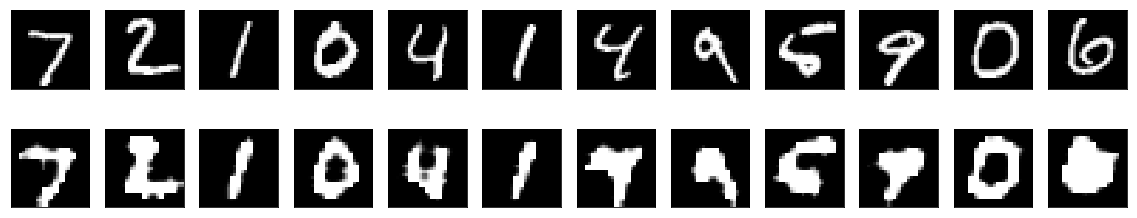

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# 何個表示するか
n = 12
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 7. Denoising Autoencoder(DAE)

### 7-1. Denoising Autoencoder とは

Autoencoderでは、基本的に損失関数が<br>
$L(x,g(f(x)))$ <br>
という形をしていて、単純に入力と出力の違いがなるべく小さくなるように学習していくのでした。

そして、Overcomplete Autoencoderというコード $h$ の次元が入力 $x$ の次元よりも大きいモデルでは、<br>
単純に値をコピーすることで、入力と出力の違いをゼロにできてしまうという問題がありました。

この問題を解決するために、Sparse Autoencoderでは $\Omega(h)$ というペナルティ項を入れました。<br>
ここでは別のアプローチを考えます。

Denoising Autoencoder (DAE)では、<br>
$L(x,g(f(\tilde{x})))$<br>
を最小化します。ここで、$\tilde{x}$は<b>入力にノイズを加えたもの</b>を表します。

<span style="color:red">ノイズが加わった入力からオリジナルの入力を復元しない</span>といけないので、
単純に値をコピーする<br>
わけにはいかなくなります。<br>
そのため、ノイズを除去するだけでなく、良い特徴を学習できるようになると考えられます。

また、別の考え方として下図のような見方をすることもできます。

<img src="03_autoencoder/denoising_map.png">

黒い線は、低次元に折りたたまれた $x$ の分布を表します。<br>
赤い印は、それぞれの訓練データに対応します。<br>

これらの訓練データにノイズを加える操作は、<br>
灰色の線のように、$x$ の分布から少し外れた場所を考えることを意味します。

緑の矢印は、ノイズが加わったデータ $\tilde{x}$ を $x$ にマッピングする様子を表しています。<br>
Denoising Autoencoderは、$\tilde{x}$ から $x$ をうまく復元できるように学習していくため、<br>
この緑の矢印を学習していると考えることもできるでしょう。

### EarlyStopping Callback

Kerasには過学習を防止するためのEarlyStopping Callbackが存在します。

コールバック - Keras Documentation<br>
https://keras.io/ja/callbacks/
    
使い方<br>
使い方は簡単で、modelのfitメソッドのcallbackに渡すだけです。

In [ ]:
from keras.callbacks import EarlyStopping
model.fit(X_train, Y_train, callbacks=[EarlyStopping(), validation_split=0.25])

### 7-2. Denoising Autoencoder の実装

まず、正規分布のノイズを加え、0から1の間の値を取るようにクリップします。

In [14]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pylab as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x
_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# numpy.clip
#    https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

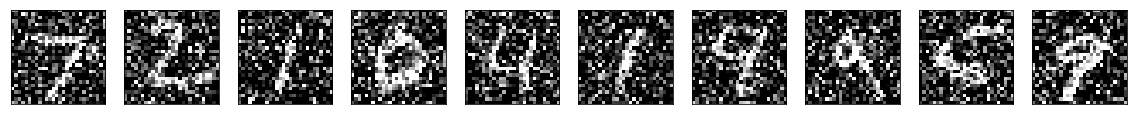

In [15]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [19]:
# callback - TensorBoard
callback_tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/autoencoder7',
                                                   histogram_freq=0, write_graph=False)
# callback - EarlyStopping
from keras.callbacks import EarlyStopping
callback_earlystop = EarlyStopping(monitor='val_loss', patience=2)

autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[callback_earlystop, callback_tensorboard])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 224s - loss: 0.1864 - val_loss: 0.1748
Epoch 2/100
60000/60000 [==============================] - 224s - loss: 0.1846 - val_loss: 0.3070
Epoch 3/100
60000/60000 [==============================] - 224s - loss: 0.1840 - val_loss: 0.1731
Epoch 4/100
60000/60000 [==============================] - 224s - loss: 0.1877 - val_loss: 0.1894
Epoch 5/100
60000/60000 [==============================] - 224s - loss: 0.1871 - val_loss: 0.1859
Epoch 6/100
60000/60000 [==============================] - 224s - loss: 0.1903 - val_loss: 0.1657
Epoch 7/100
60000/60000 [==============================] - 224s - loss: 0.1839 - val_loss: 0.1825
Epoch 8/100
60000/60000 [==============================] - 224s - loss: 0.1867 - val_loss: 0.1800
Epoch 9/100
60000/60000 [==============================] - 224s - loss: 0.1876 - val_loss: 0.1724


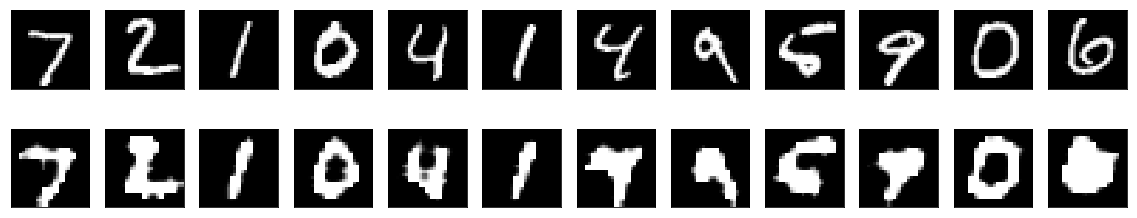

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# 何個表示するか
n = 12
plt.figure(figsize=(20, 4))
for i in range(n):
    # オリジナルのテスト画像を表示
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 変換された画像を表示
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 参考文献

Building Autoencoders in Keras<br>
https://blog.keras.io/building-autoencoders-in-keras.html

Kerasで学ぶAutoencoder<br>
https://elix-tech.github.io/ja/2016/07/17/autoencoder.html

AutoEncoderで特徴抽出<br>
https://www.slideshare.net/lewuathe/auto-encoder-v2

Chainer で Stacked Auto-Encoder を試してみた<br>
http://wazalabo.com/chainer-stacked-auto-encoder.html
